In [2]:
from google.colab import drive
drive.mount('/content/drive')  #listになかったのでドライブ上にデータ保存し、ドライブをマウント。

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/signate/モジュール系/EDA')
sys.path.append('/content/drive/MyDrive/signate/モジュール系/Feature Engineering')
sys.path.append('/content/drive/MyDrive/signate/モジュール系/meanF1')

In [4]:
### 自作モジュール
from plot_qq_plots import plot_qq_plots
from reduce_mem import reduce_mem_usage
from show_corr import show_corr
from target_encoded import get_kfold, get_targetencoding, to_target
from obj_to_cat import to_cat_data
from normalize_col import normalize_columns
from combined_features import create_combined_features
from threshold_tuning_binary import threshold_tuning_binary

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product

In [6]:
pd.set_option('display.max_columns', None)

stackingした最終推論データの重み変更

In [30]:
# clf_feat = "catboost_feat00"
# clf_feat = "lgbm_feat01"
# clf_feat = "randomforest_feat02"
# clf_feat = "logisticregression_feat03"
# clf_feat = "tabnet_feat03"
# clf_feat = "stacking_lgbm_randomforest_logisticregression_tabnet_catboost"
clf_feat = "stacking_lgbm_randomforest_logisticregression_tabnet"
# clf_feat = "stacking_lgbm_randomforest_logisticregression"
# clf_feat = "stacking_lgbm_logisticregression_tabnet_catboost"
# clf_feat = "stacking_lgbm_randomforest_logisticregression_catboost"
# clf_feat = "stacking_lgbm_logisticregression_catboost"

train = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/データセット/train.csv")
oof_pred_df = pd.read_csv(f"/content/drive/MyDrive/signate/債務不履行/model_feat/oof_pred_{clf_feat}.csv")

test = pd.read_csv(f"/content/drive/MyDrive/signate/債務不履行/データセット/test.csv")
test_pred_df = pd.read_csv(f"/content/drive/MyDrive/signate/債務不履行/model_feat/test_pred_{clf_feat}.csv")


In [8]:
weights_true = np.array(train["MIS_Status"].value_counts().sort_index()) / len(train)

100%|██████████| 500/500 [00:08<00:00, 61.00it/s] 


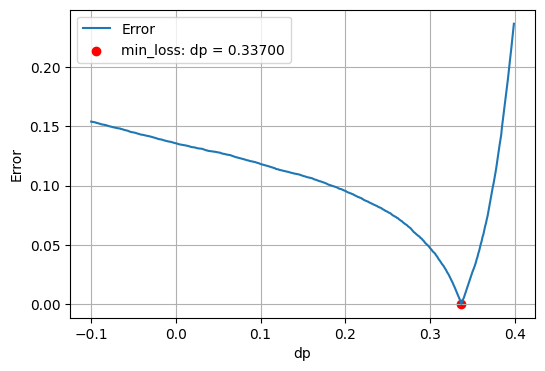

In [9]:
from sklearn.metrics import f1_score

# 解像度の設定
dp_lst = np.arange(-0.1, 0.4, 1e-3)  # 適切な範囲に調整

# F1スコア期待値が最大になる確率補正値を探索
dp_opt = threshold_tuning_binary(oof_pred_df, dp_lst, weights_true, target_col="MIS_Status")

In [10]:
# 予測確率を補正する最適なxを見つける
from sklearn.metrics import f1_score
def find_optimal_x(dp_opt, oof_pred_df, train, x_start=0.0, x_end=1.0, num_steps=1000):
    """
    dp_opt: 閾値調整パラメータ
    oof_pred_df: OOF予測結果を含むDataFrame。'MIS_Status_0'と'MIS_Status_1'列を含む
    train: 実際のターゲット値を含むDataFrame。'MIS_Status'列を含む
    x_start, x_end: xの探索範囲
    num_steps: xの探索におけるステップ数
    """
    best_f1_score = -1
    best_x = None

    for x in np.linspace(x_start, x_end, num_steps):
        # 予測確率を補正
        adjusted_pred_df = oof_pred_df.copy()
        adjusted_pred_df['MIS_Status_0'] += dp_opt
        adjusted_pred_df['MIS_Status_1'] -= dp_opt * x

        # スライドした閾値に基づくクラス分類
        oof_pred_label = np.argmax(adjusted_pred_df[['MIS_Status_0', 'MIS_Status_1']].values, axis=1)

        # mean F1スコア（マクロ平均）を計算
        y_true = train["MIS_Status"].values
        mean_f1_score_macro = f1_score(y_true, oof_pred_label, average='macro')

        # 最適なF1スコアとxを更新
        if mean_f1_score_macro > best_f1_score:
            best_f1_score = mean_f1_score_macro
            best_x = x

    return best_x, best_f1_score

# 関数を呼び出し、最適なxを探す
best_x, best_f1_score = find_optimal_x(dp_opt, oof_pred_df, train)
print(f'Optimal x: {best_x}\nMean F1 Score (Macro): {best_f1_score}')

Optimal x: 0.7937937937937938
Mean F1 Score (Macro): 0.6823549765864698


In [17]:
# 予測確率を補正
oof_pred_df['MIS_Status_0'] += dp_opt
oof_pred_df['MIS_Status_1'] -= dp_opt * 0.7937937937937938

# スライドした閾値に基づくクラス分類
oof_pred_label = np.argmax(oof_pred_df[['MIS_Status_0', 'MIS_Status_1']].values, axis=1)

In [18]:
# ユニークな要素とその出現回数を取得
unique_element, count = np.unique(oof_pred_label, return_counts=True)

# ユニークな要素の割合を計算
percentage = 100 * count / len(oof_pred_label)

print(weights_true)

# 結果を表示
for ele, percent in zip(unique_element, percentage):
    print(f"Element {ele} occurs {percent:.2f}% of the time.")

[0.10731085 0.89268915]
Element 0 occurs 8.75% of the time.
Element 1 occurs 91.25% of the time.


In [21]:
target_pct = percentage[0] #testの閾値操作で使う
target_pct

8.750325005318269

In [22]:
from sklearn.metrics import f1_score

# 実際のターゲット値
y_true = train["MIS_Status"].values

# OOF予測値をクラスに変換（argmaxを用いた変換済み）
y_oof_pred_class = oof_pred_label  # この行は既にクラスを表しているため、追加の変換は不要

# mean F1スコア（マクロ平均）を計算
mean_f1_score_macro = f1_score(y_true, y_oof_pred_class, average='macro')
print(f'Mean F1 Score (Macro): {mean_f1_score_macro}')


Mean F1 Score (Macro): 0.6810128486025939


100%|██████████| 500/500 [00:01<00:00, 295.05it/s]


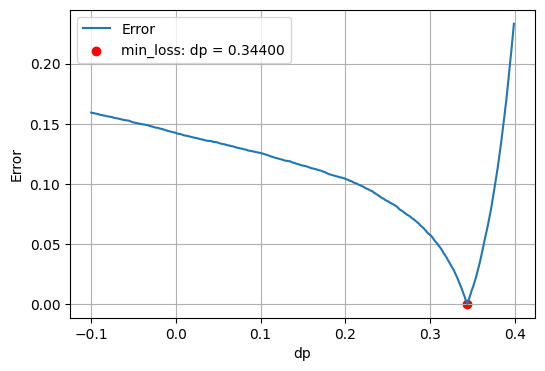

In [23]:
# 解像度の設定
dp_lst = np.arange(-0.1, 0.4, 1e-3)  # 適切な範囲に調整

# F1スコア期待値が最大になる確率補正値を探索
dp_opt = threshold_tuning_binary(test_pred_df, dp_lst, weights_true, target_col="MIS_Status")

In [24]:
# 予測確率を補正し、特定の割合に近づけるためのxの値を探す
optimal_x = None
for x in np.linspace(0, 1, 1000):
    df = test_pred_df.copy()
    # 予測確率を補正
    df['MIS_Status_0'] += dp_opt
    df['MIS_Status_1'] -= dp_opt * x

    # スライドした閾値に基づくクラス分類
    pred_label = np.argmax(df[['MIS_Status_0', 'MIS_Status_1']].values, axis=1)

    # ユニークな要素とその出現回数を取得
    unique_elements, counts = np.unique(pred_label, return_counts=True)

    # ユニークな要素の割合を計算
    percentages = 100 * counts / len(pred_label)

    # 指定された割合に近いかどうかを確認
    # ここでは、目的の値に±0.1%の範囲内であるかをチェック
    if np.abs(percentages[0] - target_pct) <= 0.01:
        optimal_x = x
        break

if optimal_x is not None:
    print(f"Found optimal x: {optimal_x}")
else:
    print("No optimal x found within the specified range.")

Found optimal x: 0.8538538538538538


In [31]:
# 予測確率を補正
test_pred_df['MIS_Status_0'] += dp_opt
test_pred_df['MIS_Status_1'] -= dp_opt * 0.9

# スライドした閾値に基づくクラス分類
pred_label = np.argmax(test_pred_df[['MIS_Status_0', 'MIS_Status_1']].values, axis=1)

In [32]:
# ユニークな要素とその出現回数を取得
unique_elements, counts = np.unique(pred_label, return_counts=True)

# ユニークな要素の割合を計算
percentages = 100 * counts / len(pred_label)

print(weights_true)

# 結果を表示
for element, percentage in zip(unique_elements, percentages):
    print(f"Element {element} occurs {percentage:.2f}% of the time.")

[0.10731085 0.89268915]
Element 0 occurs 9.24% of the time.
Element 1 occurs 90.76% of the time.


提出

In [33]:
###提出ファイルの作成

sample_submission = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/データセット/sample_submission.csv")

fin_pred = pd.DataFrame(pred_label, columns=['1'])
combined_df = pd.concat([sample_submission["0"], fin_pred], axis=1)
combined_df.columns = range(combined_df.shape[1])

# インデックスをリセット（必要に応じて古いインデックスを削除）
combined_fin_df = combined_df.reset_index(drop=True)

In [34]:
#提出ファイル出力
combined_fin_df.to_csv('/content/drive/MyDrive/signate/債務不履行/提出/submit_45_lrlt.csv', index=False)

In [ ]:
a = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/提出/submit_38.csv")
a

,0,1
0,42307,0
1,42308,1
2,42309,0
3,42310,1
4,42311,1
...,...,...
42303,84610,1
42304,84611,1
42305,84612,1
42306,84613,1


visualise

In [ ]:
# test_pred_dfは、2つのクラスに対する予測確率を含むDataFrame
# dp0_optは、クラス0に対する閾値調整の最適値

# 判定閾値をスライド
dp_df = test_pred_df.copy()
dp_df["MIS_Status_0"] = dp_df["MIS_Status_0"] + dp_opt
dp_df["MIS_Status_1"] = dp_df["MIS_Status_1"] - dp_opt


# スライドした閾値に基づくクラス分類
pred_label = np.argmax(dp_df.values, axis=1)

**メモ**  
41_lrlt opt:0.82 f1:0.682 8.45%  
42_lrlc opt:0.91 f1:0.682 7.88%  
43_llc opt:0.88 f1:0.683 7.36%  
44_lltc opt:0.89 f1:0.683 7.37%
